In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from decision_tree import DecisionTree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Testing the implementation of a decision tree for classification

## Loading the data

In [3]:
df = pd.read_csv("magic04.data", header=None)
print(f"Shape : {df.shape}")
print(f"Preview : ")
df.head()

Shape : (19020, 11)
Preview : 


,0,1,2,3,4,5,6,7,8,9,10
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


## Preparing the data

In [4]:
data = df.to_numpy()
x = data[:,:-1]
y = data[:,-1]

In [5]:
seed = 666

x_train, x_vt, y_train, y_vt = train_test_split(x, y, shuffle=True, random_state=seed)
x_val, x_test, y_val, y_test = train_test_split(x_vt, y_vt, random_state=seed)

## Comparing implementations (vs Scikit Learn)

### Accuracy 

In [6]:
# Our implementation with entropy as impurity mesurement
dt_entropy = DecisionTree()
dt_entropy.fit(x, y)

# Our implementation with gini as impurity mesurement
dt_gini = DecisionTree("gini")
dt_gini.fit(x_train, y_train)

# sklearn implementation (entropy)
sk_entropy = DecisionTreeClassifier(criterion="entropy")
sk_entropy.fit(x_train, y_train)
sk_entropy.cost_complexity_pruning_path(x_train, y_train)

# sklearn implementation (gini)
sk_gini = DecisionTreeClassifier(criterion="gini")
sk_gini.fit(x_train, y_train)
_ = sk_gini.cost_complexity_pruning_path(x_train, y_train)

In [7]:
pred = dt_entropy(x_val)
acc_dt_entropy = accuracy_score(y_val, pred)
pred = dt_gini(x_val)
acc_dt_gini = accuracy_score(y_val, pred)
pred = sk_entropy.predict(x_val)
acc_sk_entropy = accuracy_score(y_val, pred)
pred = sk_gini.predict(x_val)
acc_sk_gini = accuracy_score(y_val, pred)

accuracies = pd.DataFrame({
    "scikit learn" : {
        "gini": acc_sk_gini,
        "entropy": acc_sk_entropy
    },
    "our implmentation" : {
        "gini": acc_dt_gini,
        "entropy": acc_dt_entropy
    }
})

print("The accuracy of the different implmentations : ")
display(accuracies)

The accuracy of the different implmentations : 


,scikit learn,our implmentation
gini,0.804543,0.830342
entropy,0.805665,0.868200


### Speed comparaisons

#### Training

In [8]:
from time import time

sizes = [100, 1000, 5000, 10000, 50000, 100000]

training_times = pd.DataFrame({
    "size": {},
    "sklearn gini" : {},
    "sklearn entropy" : {},
    "sklearn gini no pruning" : {},
    "sklearn entropy no pruning" : {},
    "ours gini" : {},
    "ours entropy" : {},
    "ours gini no pruning" : {},
    "ours entropy no pruning" : {}
})

inferance_times = pd.DataFrame({
    "size": {},
    "sklearn gini" : {},
    "sklearn entropy" : {},
    "sklearn gini no pruning" : {},
    "sklearn entropy no pruning" : {},
    "ours gini" : {},
    "ours entropy" : {},
    "ours gini no pruning" : {},
    "ours entropy no pruning" : {}
})


def time_function(f):
    timer = time()
    f()
    return time() - timer

def benchmark(label, x, y):
    dt_entropy = DecisionTree()
    dt_gini = DecisionTree("gini")
    sk_entropy = DecisionTreeClassifier(criterion="entropy")
    sk_gini = DecisionTreeClassifier(criterion="gini")

    dt_entropy_np = DecisionTree()
    dt_gini_np = DecisionTree("gini")
    sk_entropy_np = DecisionTreeClassifier(criterion="entropy")
    sk_gini_np = DecisionTreeClassifier(criterion="gini")

    dt_entropy_time = time_function(
        lambda: dt_entropy.fit(x, y)
    )

    dt_gini_time = time_function(
        lambda: dt_gini.fit(x, y)
    )

    dt_entropy_time_np = time_function(
        lambda: dt_entropy_np.fit(x, y, skip_pruning=True)
    )

    dt_gini_time_np = time_function(
        lambda: dt_gini_np.fit(x, y, skip_pruning=True)
    )

    sk_entropy_time_np = time_function(
        lambda: sk_entropy.fit(x, y)
    )
    sk_entropy_np = deepcopy(sk_entropy)
    sk_entropy_time = time_function(
        lambda: sk_entropy.cost_complexity_pruning_path(x, y)
    ) + sk_entropy_time_np

    sk_gini_time_np = time_function(
        lambda: sk_gini.fit(x, y)
    )
    sk_gini_np = deepcopy(sk_gini)
    sk_gini_time = time_function(
        lambda: sk_gini.cost_complexity_pruning_path(x, y)
    ) + sk_gini_time_np

    training_time = pd.DataFrame({
        "size" : {label: len(y)},
        "sklearn gini" : {label: sk_gini_time},
        "sklearn entropy" : {label: sk_entropy_time},
        "sklearn gini no pruning" : {label: sk_gini_time_np},
        "sklearn entropy no pruning" : {label: sk_entropy_time_np},
        "ours gini" : {label: dt_gini_time},
        "ours entropy" : {label: dt_entropy_time},
        "ours gini no pruning" : {label: dt_gini_time_np},
        "ours entropy no pruning" : {label: dt_entropy_time_np}
    })    

    dt_entropy_time = time_function(
        lambda: dt_entropy.predict(x)
    )

    dt_gini_time = time_function(
        lambda: dt_gini.predict(x)
    )

    dt_entropy_time_np = time_function(
        lambda: dt_entropy_np.predict(x)
    )

    dt_gini_time_np = time_function(
        lambda: dt_gini_np.predict(x)
    )

    sk_entropy_time = time_function(
        lambda: sk_entropy.predict(x)
    )
    sk_entropy_time_np = time_function(
        lambda: sk_entropy_np.predict(x)
    )

    sk_gini_time = time_function(
        lambda: sk_gini.predict(x)
    )
    sk_gini_time_np = time_function(
        lambda: sk_gini_np.predict(x)
    )

    inferance_time = pd.DataFrame({
        "size" : {label: len(y)},
        "sklearn gini" : {label: sk_gini_time},
        "sklearn entropy" : {label: sk_entropy_time},
        "sklearn gini no pruning" : {label: sk_gini_time_np},
        "sklearn entropy no pruning" : {label: sk_entropy_time_np},
        "ours gini" : {label: dt_gini_time},
        "ours entropy" : {label: dt_entropy_time},
        "ours gini no pruning" : {label: dt_gini_time_np},
        "ours entropy no pruning" : {label: dt_entropy_time_np}
    })

    return training_time, inferance_time

for size in sizes:
    x = np.random.rand(size, 10)
    y = np.random.randint(0, 2, size=(size,))

    training_time, inferance_time = benchmark(f"Random({size})", x, y)

    training_times = pd.concat([
        training_times,
        training_time
    ])

    inferance_times = pd.concat([
        inferance_times,
        inferance_time        
    ])

training_time, inferance_time = benchmark(f"Real Dataset({len(y_train)})", x_train, y_train)

training_times = pd.concat([
    training_times,
    training_time
])

inferance_times = pd.concat([
    inferance_times,
    inferance_time        
])

print("Training duration of the implementation of the decision tree against the scikit-learn implementation : ")
display(training_times)
print("Inference duration of the implementation of the decision tree against the scikit-learn implementation : ")
display(inferance_times)

Training duration of the implementation of the decision tree against the scikit-learn implementation : 


,size,sklearn gini,sklearn entropy,sklearn gini no pruning,sklearn entropy no pruning,ours gini,ours entropy,ours gini no pruning,ours entropy no pruning
Random(100),100.0,0.001882,0.002370,0.000958,0.001172,0.008189,0.009246,0.007329,0.007735
Random(1000),1000.0,0.016267,0.027674,0.007508,0.013662,0.080089,0.080761,0.072687,0.073730
Random(5000),5000.0,0.182204,0.263704,0.087914,0.129792,0.438149,0.438669,0.415644,0.409316
Random(10000),10000.0,0.386553,0.595262,0.181556,0.288868,0.943503,0.925951,0.971766,0.914520
Random(50000),50000.0,3.194247,5.378339,1.331315,2.480305,5.258784,4.910149,4.652867,4.903723
Random(100000),100000.0,9.109366,12.908240,3.548168,5.672144,9.488106,9.705441,8.645318,8.828237
Real Dataset(14265),14265.0,0.429145,0.451046,0.212405,0.220252,0.730407,0.730310,0.705866,0.689217


Inference duration of the implementation of the decision tree against the scikit-learn implementation : 


,size,sklearn gini,sklearn entropy,sklearn gini no pruning,sklearn entropy no pruning,ours gini,ours entropy,ours gini no pruning,ours entropy no pruning
Random(100),100.0,0.000071,0.000107,0.000066,0.000077,0.000019,0.000039,0.000411,0.000439
Random(1000),1000.0,0.000158,0.000278,0.000150,0.000172,0.001036,0.001216,0.004891,0.003864
Random(5000),5000.0,0.000689,0.000867,0.000678,0.000767,0.006620,0.006025,0.021959,0.022111
Random(10000),10000.0,0.001925,0.001693,0.001977,0.001665,0.013923,0.013841,0.044359,0.044376
Random(50000),50000.0,0.011683,0.012640,0.011751,0.012414,0.075533,0.072582,0.225704,0.226079
Random(100000),100000.0,0.031475,0.028736,0.030524,0.031828,0.143312,0.140240,0.425203,0.421446
Real Dataset(14265),14265.0,0.007897,0.007939,0.007839,0.007537,0.035815,0.028239,0.061399,0.069136


Text(0.5, 1.0, 'Inference durations for the implementations of DecisionTreeClassifier (pruning diasbled)')

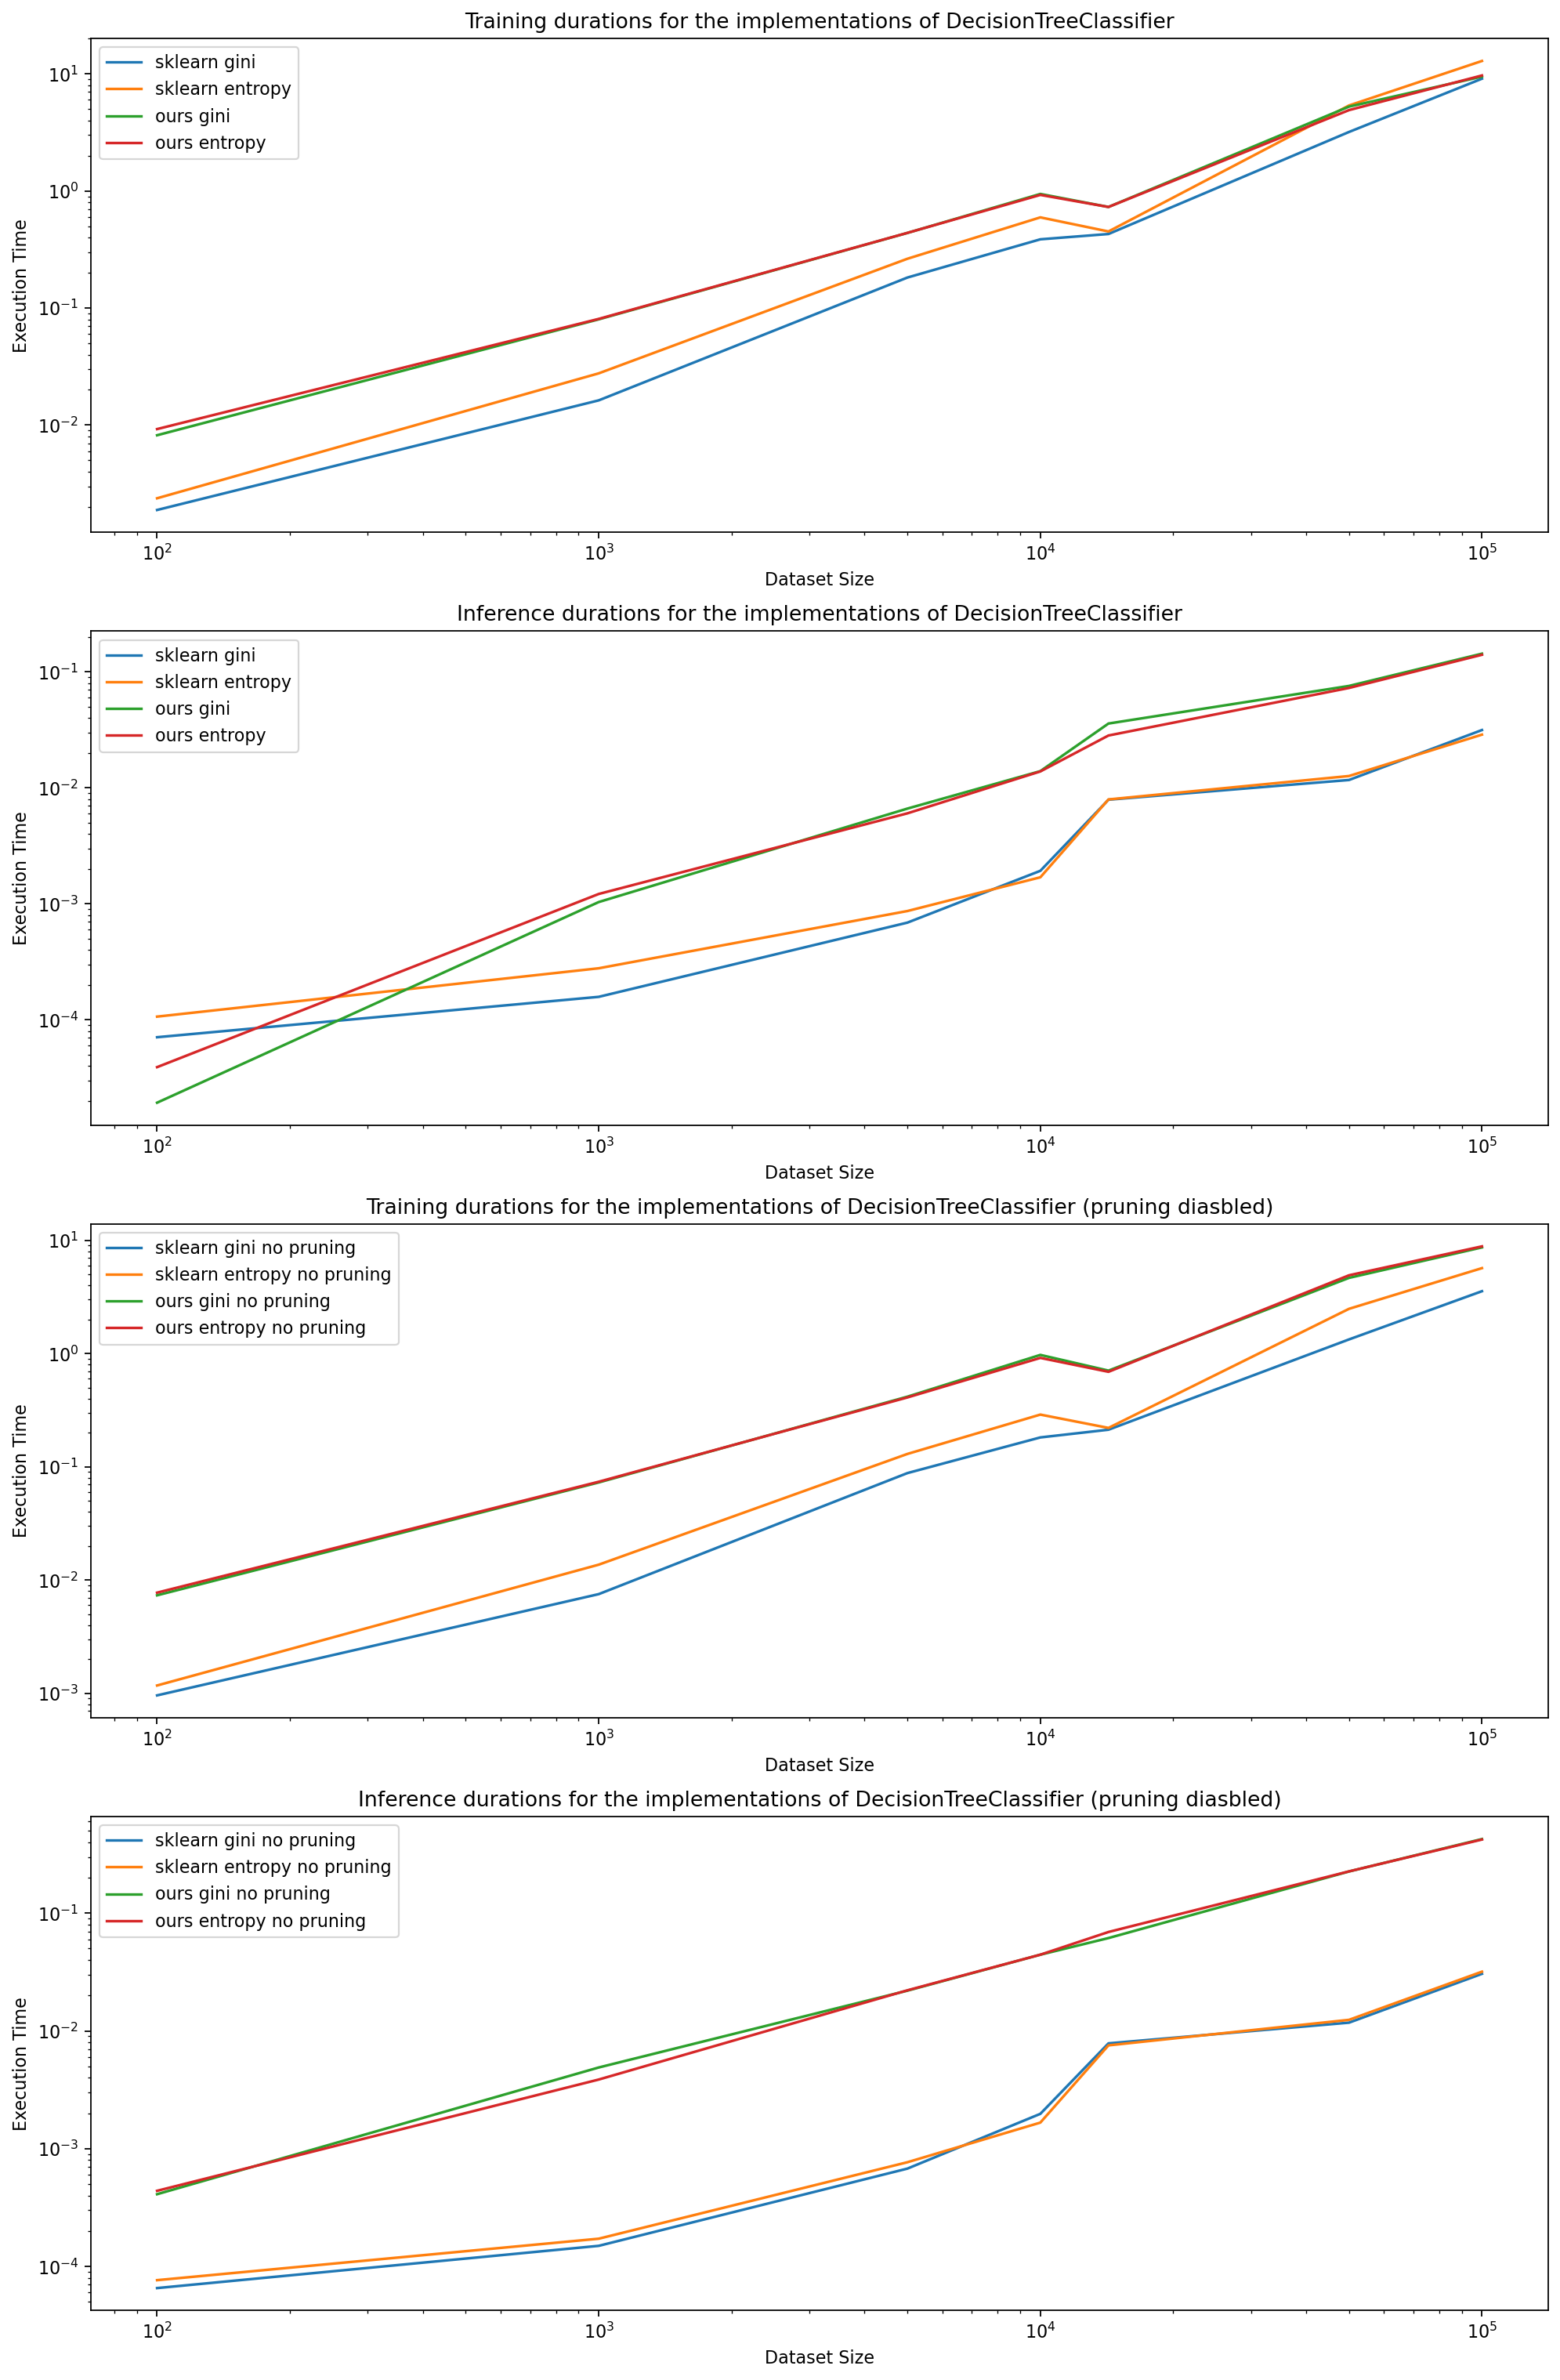

In [9]:
training_times = training_times.sort_values("size")
inferance_times = inferance_times.sort_values("size")

columns_p = [x for x in training_times.columns if x != "size" and "no pruning" not in x ]
columns_np = [x for x in training_times.columns if x != "size" and "no pruning" in x ]

fig, axs = plt.subplots(4, 1, figsize=(15, 24), dpi=160)



for column in columns_p:
    training_times.plot.line("size", column, ax=axs[0])
    inferance_times.plot.line("size", column, ax=axs[1])

for column in columns_np:
    training_times.plot.line("size", column, ax=axs[2])
    inferance_times.plot.line("size", column, ax=axs[3])

for ax in axs:
    ax.set_yscale("log")
    ax.set_ylabel("Execution Time")
    ax.set_xscale("log")
    ax.set_xlabel("Dataset Size")

axs[0].set_title("Training durations for the implementations of DecisionTreeClassifier")
axs[1].set_title("Inference durations for the implementations of DecisionTreeClassifier")
axs[2].set_title("Training durations for the implementations of DecisionTreeClassifier (pruning diasbled)")
axs[3].set_title("Inference durations for the implementations of DecisionTreeClassifier (pruning diasbled)")

## Testing the selected model

In [13]:
pred_test = dt_entropy(x_test)
test_acc = accuracy_score(y_test, pred_test)
print(f"The selected model achieved {test_acc} accuracy on the test set")

The selected model achieved 0.8738435660218671 accuracy on the test set
